# Super Resolution using CNN

**Important:** Before proceed, go to Edit -> Notebook settings to make sure you've selected TPU as Hardware accelerator

## Preparation

### Download data from GCS

In [1]:
!gsutil cp gs://project3ads/image_data.tar.gz dataset.tar.gz
  
!gunzip -c dataset.tar.gz | tar xopf -

Copying gs://project3ads/image_data.tar.gz...
\ [1 files][215.5 MiB/215.5 MiB]                                                
Operation completed over 1 objects/215.5 MiB.                                    


In [0]:
path_HR = "./train_set/HR/"
path_LR = "./train_set/LR/"

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def plot_img(img):
  plt.imshow(img)
  plt.axis('off')
  plt.show()

### Split training, testing and validation set

In [0]:
# split to training, test and validation set
import random
import math
import os

train_percentage = 0.7
validation_percentage = 0.2
test_percentage = 1 - train_percentage - validation_percentage

imgs_name = np.unique(np.array([x.replace('._','') for x in os.listdir(path_HR)]))
n = len(imgs_name)
indices = np.array(list(range(0, n)))
# randomly draw train_percentage * n samples from that array and move corresponding files to train
train_and_val = np.array(random.sample(range(0, n), math.floor((train_percentage+validation_percentage) * n)))
train_indices = train_and_val[0: math.floor(train_percentage*n)+1]
val_indices = train_and_val[math.floor(train_percentage*n)+1: ]
# randomly draw validation_percentage * n samples from the rest and move to valid
test_indices = np.delete(indices, train_and_val)

train_n = len(train_indices)
val_n = len(val_indices)
test_n = len(test_indices)

### Define generators to feed data into the model for training purpose

In [0]:
target_shape = (430, 568, 3)

def preprocess_img(name, method):
  input_img = Image.open(path_LR + name)
  output_img = Image.open(path_HR + name)
  
  if method == 'flip':
    input_img = input_img.transpose(Image.FLIP_TOP_BOTTOM)
    output_img = output_img.transpose(Image.FLIP_TOP_BOTTOM)
  
  input_img = input_img.resize((target_shape[1], target_shape[0]), Image.BICUBIC)
  output_img = output_img.resize((target_shape[1], target_shape[0]), Image.BICUBIC)
  
  
    
  input_img = np.array(input_img)
  output_img = np.array(output_img)
  input_img = input_img / 255.0
  output_img = output_img / 255.0
  
  return (input_img, output_img)
      

def image_generator(input_path, output_path, names, batch_size = 16):
    
  while True:
    
    num_of_images = math.floor(batch_size / 2)
    
    batch_paths = np.random.choice(a = names, 
                                   size = num_of_images)

    batch_input = np.zeros([batch_size, target_shape[0], target_shape[1], 3])
    batch_output = np.zeros([batch_size, target_shape[0], target_shape[1], 3])
    i = 0

    # Read in each input, perform preprocessing and get labels  
    
    for name in batch_paths:
 
      (input_img, output_img) = preprocess_img(name, 'normal')      
      batch_input[i] = input_img 
      batch_output[i] = output_img
      i += 1
      if i >= batch_size:
        break
        
      
      (input_img, output_img) = preprocess_img(name, 'flip')      
      batch_input[i] = input_img 
      batch_output[i] = output_img
      i += 1
      if i >= batch_size:
        break
        
    
    
    # Return a tuple of (input,output) to feed the network
    batch_x = np.array( batch_input )
    batch_y = np.array( batch_output )
    
    
    
    yield( batch_x, batch_y )
    
    
def val_image_generator(input_path, output_path, names, batch_size = 16):
    
  while True:
    
    batch_paths = np.random.choice(a = names, 
                                   size = batch_size)

    batch_input = np.zeros([batch_size, target_shape[0], target_shape[1], 3])
    batch_output = np.zeros([batch_size, target_shape[0], target_shape[1], 3])
    i = 0

    # Read in each input, perform preprocessing and get labels  
    
    for name in batch_paths:
 
      (input_img, output_img) = preprocess_img(name, 'normal')      
      batch_input[i] = input_img 
      batch_output[i] = output_img
      i += 1
      
    
    # Return a tuple of (input,output) to feed the network
    batch_x = np.array( batch_input )
    batch_y = np.array( batch_output )
    
    
    
    yield( batch_x, batch_y )

## Model definition

Use the model mentioned here as a reference: **DSRCNN model **https://github.com/titu1994/Image-Super-Resolution

![Graph for DSRCNN model](https://raw.githubusercontent.com/titu1994/ImageSuperResolution/master/architectures/Denoise.png)

In [7]:
import tensorflow as tf

init = tf.keras.layers.Input(shape = target_shape)
level1_1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(init)
level2_1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(level1_1)

level2_2 = tf.keras.layers.Convolution2DTranspose(64, (3, 3), activation='relu', padding='same')(level2_1)
level2 = tf.keras.layers.Add()([level2_1, level2_2])

level1_2 = tf.keras.layers.Convolution2DTranspose(64, (3, 3), activation='relu', padding='same')(level2)
level1 = tf.keras.layers.Add()([level1_1, level1_2])

decoded = tf.keras.layers.Conv2D(3, (5, 5), activation='linear', padding='same')(level1)

model = tf.keras.models.Model(init, decoded)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 430, 568, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 430, 568, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 430, 568, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 430, 568, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
add (Add) 

In [9]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

def PSNRLoss(y_true, y_pred):
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    """
    return -10. * tf.keras.backend.log(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true))) / tf.keras.backend.log(10.)

tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss='mse', 
    metrics=[PSNRLoss]
)  

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.116.66.106:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 12956587062940411332)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3902986436435976879)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 18245817929401484669)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3056968668840321071)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 17971001194593511051)
INFO:tensorflow:*** Available Device: _Devi

### fit the model with data generator. Will take ~12mins for training

In [10]:
tpu_model.fit_generator(
    image_generator(path_LR, path_HR, imgs_name[train_indices]),
    epochs=10,
    steps_per_epoch=50,
    validation_data= val_image_generator(path_LR, path_HR, imgs_name[val_indices]),
    validation_steps=10,
)

Epoch 1/10
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(2, 430, 568, 3), dtype=tf.float32, name='input_1_20'), TensorSpec(shape=(2, 430, 568, 3), dtype=tf.float32, name='conv2d_2_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 7.5499186515808105 secs
INFO:tensorflow:Setting weights on TPU model.
49/50 [============================>.] - ETA: 1s - loss: 0.0163 - PSNRLoss: 20.8515INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(2, 430, 568, 3), dtype=tf.float32, name='input_1_20'), TensorSpec(shape=(2, 430, 568, 3), dtype=tf.float32, name='conv2d_2_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping p

**Save trained model**

In [12]:
tpu_model.save('tpu_model')

INFO:tensorflow:Copying TPU weights to the CPU


## Testing Model

### Load model and compile again

In [0]:
# import tensorflow as tf
# def PSNRLoss(y_true, y_pred):
#     """
#     PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
#     It can be calculated as
#     PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
#     """
#     return -10. * tf.keras.backend.log(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true))) / tf.keras.backend.log(10.)

# model_tpu = tf.keras.models.load_model('tpu_model') 

# model_tpu.compile(
#     optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
#     loss='mse', 
#     metrics=[PSNRLoss]
# )  

### Prepare testing data

In [14]:
test_imgs = np.zeros([len(test_indices), target_shape[0], target_shape[1], 3])
test_imgs_truth = []
test_imgs_truth_size = np.zeros([len(test_indices), 2])
i = 0
print("total number of test images is " + str(len(test_indices)))
for indice in test_indices:

  img_input = Image.open(path_LR + imgs_name[indice])
  img_truth = Image.open(path_HR + imgs_name[indice])
  
  img_input = img_input.resize((target_shape[1], target_shape[0]), Image.BICUBIC)
  test_imgs_truth_size[i] = img_truth.size
  
  img_input = np.array(img_input)
  img_truth = np.array(img_truth)
  img_input = img_input / 255.0
  img_truth = img_truth / 255.0


  
  test_imgs[i] = img_input 
  test_imgs_truth.append(img_truth)
  
  i = i+1

total number of test images is 151


### Predict using the trained model

In [15]:
cpu_model = tpu_model.sync_to_cpu()
predicted_img = cpu_model.predict(test_imgs)

INFO:tensorflow:Copying TPU weights to the CPU


The predicted output from the model is of shape target_shape = (430, 568, 3). Need to resize it for comparison

In [0]:
i = 0
model_predicted_img_real_size = []
for img in predicted_img:
  temp = img*255
  temp[temp > 255] = 255
  temp[temp < 0] = 0
  temp = Image.fromarray(temp.astype('uint8'))
  temp = temp.resize(test_imgs_truth_size[i].astype('int'))
  model_predicted_img_real_size.append(np.array(temp)/255.0)

  i = i + 1

### Take a look at the predicted images...

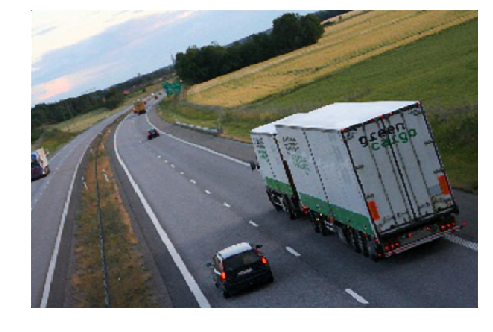

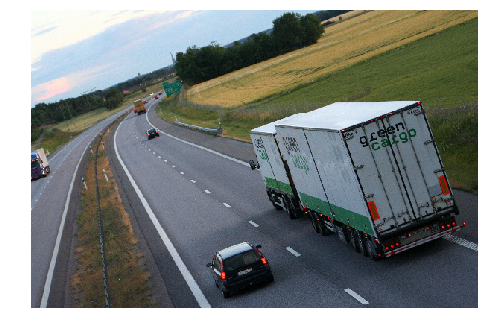

In [17]:
plot_img(model_predicted_img_real_size[9])
plot_img(test_imgs_truth[9])

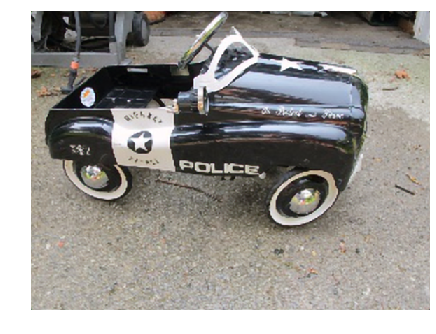

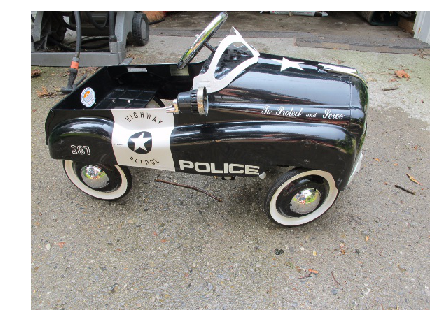

In [18]:
plot_img(model_predicted_img_real_size[30])
plot_img(test_imgs_truth[30])

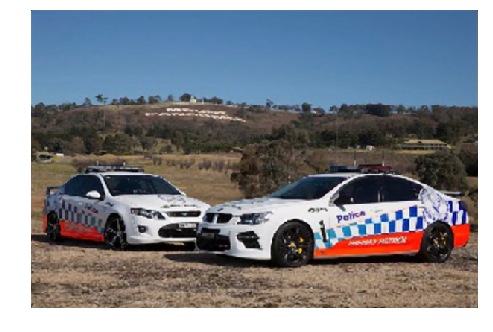

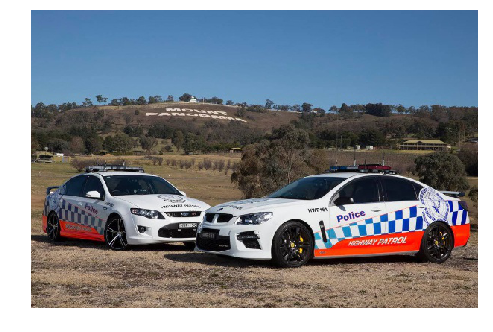

In [19]:
plot_img(model_predicted_img_real_size[20])
plot_img(test_imgs_truth[20])

A list of all the testing images

In [20]:
np.sort(imgs_name[test_indices])

array(['img_0002.jpg', 'img_0008.jpg', 'img_0012.jpg', 'img_0024.jpg',
       'img_0034.jpg', 'img_0035.jpg', 'img_0044.jpg', 'img_0046.jpg',
       'img_0065.jpg', 'img_0071.jpg', 'img_0073.jpg', 'img_0106.jpg',
       'img_0127.jpg', 'img_0135.jpg', 'img_0136.jpg', 'img_0151.jpg',
       'img_0176.jpg', 'img_0178.jpg', 'img_0190.jpg', 'img_0192.jpg',
       'img_0201.jpg', 'img_0208.jpg', 'img_0215.jpg', 'img_0235.jpg',
       'img_0260.jpg', 'img_0270.jpg', 'img_0273.jpg', 'img_0274.jpg',
       'img_0291.jpg', 'img_0298.jpg', 'img_0323.jpg', 'img_0325.jpg',
       'img_0345.jpg', 'img_0362.jpg', 'img_0381.jpg', 'img_0392.jpg',
       'img_0397.jpg', 'img_0411.jpg', 'img_0412.jpg', 'img_0439.jpg',
       'img_0456.jpg', 'img_0461.jpg', 'img_0485.jpg', 'img_0496.jpg',
       'img_0511.jpg', 'img_0513.jpg', 'img_0529.jpg', 'img_0532.jpg',
       'img_0533.jpg', 'img_0534.jpg', 'img_0546.jpg', 'img_0547.jpg',
       'img_0562.jpg', 'img_0564.jpg', 'img_0574.jpg', 'img_0576.jpg',
      

### Calculate the average PSNR in testing data 

In [0]:
def psnr(y_true, y_pred):
    return -10. * np.log(np.mean(np.square(y_pred - y_true))) / np.log(10.)
  
psnr_predicted = np.zeros(len(test_imgs_truth))
for i in range(len(test_imgs_truth)):  
  psnr_predicted[i] = psnr(test_imgs_truth[i], model_predicted_img_real_size[i])

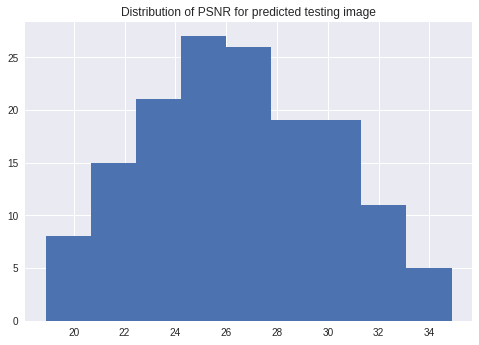

In [19]:
plt.hist(psnr_predicted, bins = 'auto')
plt.title('Distribution of PSNR for predicted testing image')
plt.show()

**Comparing with results from Bicubic**

In [0]:
psnr_bicubic = np.zeros(len(test_imgs_truth))
for i in range(len(test_imgs_truth)):
  # read in test images and reshape it to target images
  img_input = Image.open(path_LR + imgs_name[test_indices[i]])
  
  img_input = img_input.resize(test_imgs_truth_size[i].astype('int'), Image.BICUBIC)
  img_input = np.array(img_input) / 255.0

  psnr_bicubic[i] = psnr(test_imgs_truth[i], img_input)
  

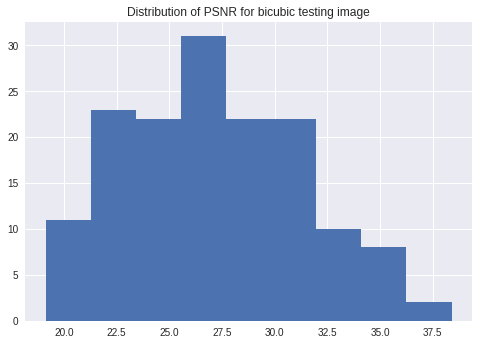

In [21]:
plt.hist(psnr_bicubic, bins = 'auto')
plt.title('Distribution of PSNR for bicubic testing image')
plt.show()

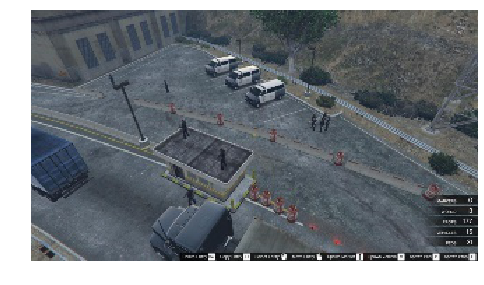

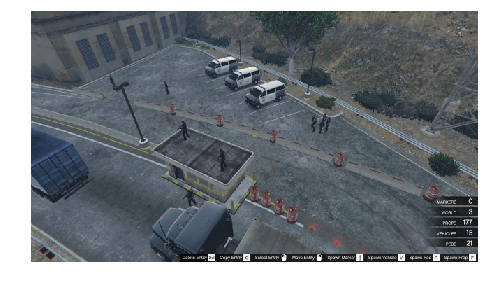

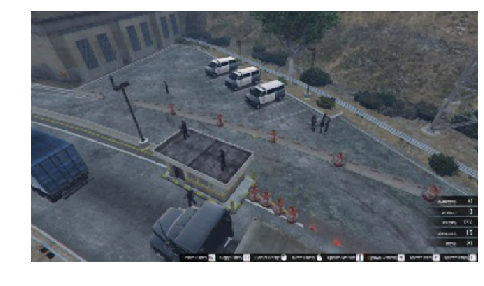

In [22]:
img_input = Image.open(path_LR + imgs_name[test_indices[0]])
plot_img(img_input)
plot_img(test_imgs_truth[0])
plot_img(model_predicted_img_real_size[0])

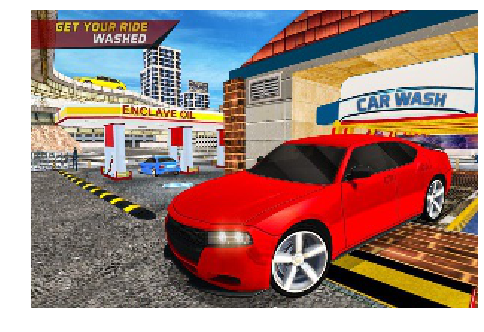

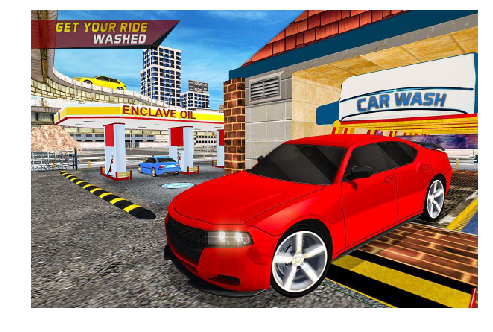

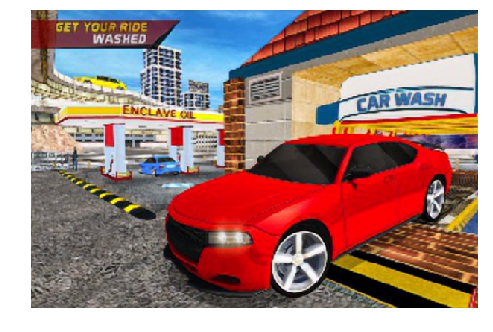

In [23]:
img_input = Image.open(path_LR + imgs_name[test_indices[10]])
plot_img(img_input)
plot_img(test_imgs_truth[10])
plot_img(model_predicted_img_real_size[10])

**The CNN model clearly presents results that are visually better than bicubic**

## Run prediction for the 1000 images

First we need to upload the test set to Google Cloud, then load the data by the following step.

In [31]:
!gsutil cp gs://adsproject3/test_set.tar.gz dataset.tar.gz
  
!gunzip -c dataset.tar.gz | tar xopf -

Copying gs://adsproject3/test_set.tar.gz...
\ [1 files][ 72.4 MiB/ 72.4 MiB]                                                
Operation completed over 1 objects/72.4 MiB.                                     


In [0]:
import numpy as np
import os
from PIL import Image
path_HR = "./test_SecTwo/HR/"
path_LR = "./test_SecTwo/LR/"
target_shape = (430, 568, 3)

imgs_name = np.unique(np.array([x.replace('._','') for x in os.listdir(path_HR)]))
imgs_to_predict = imgs_name
# np.sort(imgs_name)[0:1000]


In [35]:
!mkdir predicted_images

mkdir: cannot create directory ‘predicted_images’: File exists


**Make predictions (need to write a data generator since image data cannot fit in the memory)**

In [0]:
def test_image_generator(input_path, output_path, names, true_image_size, batch_size = 32):
    
  i = 0
  done = False
  current_size = batch_size
  while True:
    if((i+1)*batch_size > len(names)):
      batch_paths = names[i*batch_size: len(names)]
      current_size = len(names) - i*batch_size
      done = True
    else:
      batch_paths = names[i*current_size: (i+1)*current_size]

    
      
    batch_input = np.zeros([current_size, target_shape[0], target_shape[1], 3])
#     batch_output = np.zeros([current_size, target_shape[0], target_shape[1], 3])

    # Read in each input, perform preprocessing and get labels  
    j = 0
    for name in batch_paths:
      (input_img, output_img) = preprocess_img(name, 'normal')
      batch_input[j] = input_img 
#       batch_output[j] = output_img
      output_img = Image.open(path_HR + name)
      true_image_size[i*batch_size + j] = output_img.size
      j = j + 1
    
    
    
    # Return a tuple of (input,output) to feed the network
    batch_x = np.array( batch_input )
#     batch_y = np.array( batch_output )
    
    i = i + 1
   
    
#     yield( batch_x, batch_y )
    yield(batch_x)
  
    if(done):
      break

In [37]:
images_each_round = 100
current_images_per_round = images_each_round
for i in range(math.floor(1000/images_each_round)+1):
  
  start_index = i*images_each_round
  end_index = (i+1)*images_each_round
  if(end_index > 1000):
    end_index = 1000
  
  if(start_index == 1000):
    break
  
  print('proecssing images from image '+str(start_index) + ' to image ' + str(end_index) + '.....')
  
  true_image_size = np.zeros([current_images_per_round, 2])
  
  # run prediction for current batch
  predicted_img = cpu_model.predict_generator(
    test_image_generator(path_LR, path_HR, imgs_to_predict[start_index: end_index], true_image_size, batch_size = 32),
    steps = images_each_round//32 + 1
  )
  
  print('finished process current range. Now save imgs...')
 
  # save results of current batch
  
  j = 0
  

  
  for img in predicted_img:
    temp = img*255
    temp[temp > 255] = 255
    temp[temp < 0] = 0
    temp = Image.fromarray(temp.astype('uint8'))
    temp = temp.resize(true_image_size[j].astype('int'))
    
    temp.save('predicted_images/' + imgs_to_predict[i*images_each_round+j], "JPEG", quality=80, optimize=True, progressive=True)

    j = j + 1
    
    
    print('saved image '+imgs_to_predict[i*images_each_round+j-1])
  
  print('')
  
  if (i+1) * images_each_round > 1000:
    current_images_per_round = 1000 - i * images_each_round

proecssing images from image 0 to image 100.....
finished process current range. Now save imgs...
saved image img_0001.jpg
saved image img_0002.jpg
saved image img_0003.jpg
saved image img_0004.jpg
saved image img_0005.jpg
saved image img_0006.jpg
saved image img_0007.jpg
saved image img_0008.jpg
saved image img_0009.jpg
saved image img_0010.jpg
saved image img_0011.jpg
saved image img_0012.jpg
saved image img_0013.jpg
saved image img_0014.jpg
saved image img_0015.jpg
saved image img_0016.jpg
saved image img_0017.jpg
saved image img_0018.jpg
saved image img_0019.jpg
saved image img_0020.jpg
saved image img_0021.jpg
saved image img_0022.jpg
saved image img_0023.jpg
saved image img_0024.jpg
saved image img_0025.jpg
saved image img_0026.jpg
saved image img_0027.jpg
saved image img_0028.jpg
saved image img_0029.jpg
saved image img_0030.jpg
saved image img_0031.jpg
saved image img_0032.jpg
saved image img_0033.jpg
saved image img_0034.jpg
saved image img_0035.jpg
saved image img_0036.jpg
sa

It takes about 5min to predict and store 1000 images.

### Store predicted images to local drive

In [38]:
!zip -r predicted_images.zip predicted_images

updating: predicted_images/ (stored 0%)
updating: predicted_images/img_0629.jpg (deflated 1%)
updating: predicted_images/img_0161.jpg (deflated 3%)
updating: predicted_images/img_0565.jpg (deflated 1%)
updating: predicted_images/img_0288.jpg (deflated 1%)
updating: predicted_images/img_0948.jpg (deflated 1%)
updating: predicted_images/img_0715.jpg (deflated 1%)
updating: predicted_images/img_0682.jpg (deflated 1%)
updating: predicted_images/img_0343.jpg (deflated 1%)
updating: predicted_images/img_0604.jpg (deflated 1%)
updating: predicted_images/img_0681.jpg (deflated 1%)
updating: predicted_images/img_0888.jpg (deflated 1%)
updating: predicted_images/img_0916.jpg (deflated 1%)
updating: predicted_images/img_0100.jpg (deflated 1%)
updating: predicted_images/img_0920.jpg (deflated 1%)
updating: predicted_images/img_0533.jpg (deflated 1%)
updating: predicted_images/img_0327.jpg (deflated 1%)
updating: predicted_images/img_0808.jpg (deflated 1%)
updating: predicted_images/img_0050.jpg (d

In [0]:
from google.colab import files
files.download('predicted_images.zip') 